In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


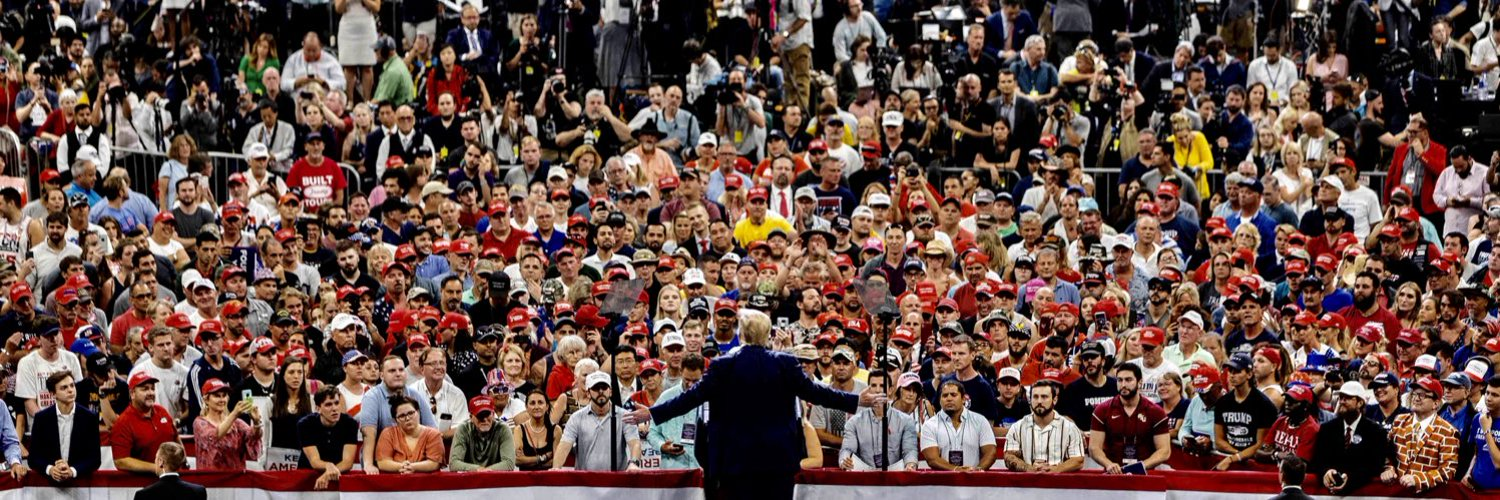

In [2]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/Colab Projects/trump/djt-twitterheader.jpeg') 

Source: [Header photo of Donald Trump's Twitter account](https://twitter.com/realDonaldTrump/header_photo)

## Introduction

Out of all the social media platforms in operation today, Twitter is potentially the best at being able to quickly find out what's happening in the world. A constant stream of once 140, but recently 280-character messages show what people think about sports, entertainment, politics, and more. At least within the context of the U.S.A., Twitter has been used increasingly in the past few years by politicians to give the public an idea of what actually goes on in government --- however opinionated their statements may seem. With that in mind, there *was* likely no Twitter account followed more closely than that of the former 45th President, Donald Trump. 

Trump's timeline provided for a relatively public view of how he aimed to run the country and convey the office of the presidency, as it should have. Regardless of what he said, good or bad, CNN, Fox News, the Washington Post, and other news organizations spent considerable effort giving his tweets attention and debating the resulting impact on the country. It was no secret that President Trump is a Republican and wasted no time speaking out against celebrities, congressmen, senators, governors, aspiring candidates, and others on the other side of political aisle. It was also fairly obvious to see that President Trump's tweets grabbed headlines and that he rushes to defend himself on the platform in the face of questionable decisions or damaging legal investigations. On January 8, 2021, Twitter made the controversial decision to permanently suspend Trump's account. The justification given by Twitter was various tweets made that incited violence, resulting in the storming of the Capital 2 days prior, when Congress was formally counting the electoral votes of the 2020 presidential election. To read the company's full statement, check the link in the references section at the bottom of this notebook.

This notebook will attempt to go through the entirety of Donald Trump's archived Twitter timeline and provide insights into how he used the platform. At the end, just for fun, there will also be a generator that uses a pre-trained language model to construct new tweets of Trump's likeness.

*Disclaimer: I do not support ANY of the statements made in the tweets and merely presenting/discussing the data.* 

## Cleanup & First Insights

In [3]:
import pandas as pd
import numpy as np
import os
import time 
import re
from datetime import datetime

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import cufflinks as cf

pd.set_option('display.max_colwidth', None)
pio.renderers.default = 'colab'
cf.go_offline()

gdrive_path = '/content/drive/My Drive/Colab Projects/trump/djt01082021-final-json.json'

tweets = pd.read_json(gdrive_path)

tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916600,Republicans and Democrats have both created our economic problems.,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070300,"I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y",f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820600,RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015600,"The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp; the Democrats know it. Almost all recent elections using this system, even though much smaller &amp; with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp; Fraud!",f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554898000,RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those articles and tho…,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56571 entries, 0 to 56570
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         56571 non-null  int64         
 1   text       56571 non-null  object        
 2   isRetweet  56571 non-null  object        
 3   isDeleted  56571 non-null  object        
 4   device     56571 non-null  object        
 5   favorites  56571 non-null  int64         
 6   retweets   56571 non-null  int64         
 7   date       56571 non-null  datetime64[ns]
 8   isFlagged  56571 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 3.9+ MB


In [5]:
tweets['created_at'] = pd.to_datetime(tweets['date'], format = '%Y-%m-%d %H:%M:%S')
tweets['created_at'].head()

0   2011-08-02 18:07:48
1   2020-03-03 01:34:50
2   2020-01-17 03:22:47
3   2020-09-12 20:10:58
4   2020-01-17 13:13:59
Name: created_at, dtype: datetime64[ns]

The times indicated above are from UTC+0000/Greenwich Median Time/U.K Time. Since Donald Trump occasionally resided in the White House and conducted his business around D.C./New York/Florida, it is best to convert those times to Eastern Standard Time/UTC-0500 as a frame of reference for when he tweeted.

In [6]:
tweets['created_at'] = tweets['created_at'].dt.tz_localize('UTC')
tweets['created_at'] = tweets['created_at'].dt.tz_convert('US/Eastern')
tweets['created_at'].head()

0   2011-08-02 14:07:48-04:00
1   2020-03-02 20:34:50-05:00
2   2020-01-16 22:22:47-05:00
3   2020-09-12 16:10:58-04:00
4   2020-01-17 08:13:59-05:00
Name: created_at, dtype: datetime64[ns, US/Eastern]

Since this notebook aims to examine tweets themselves and not the content of any external sources, the URLs need to be removed from the text. For instance, Mr. Trump occasionally made tweets that included direct links to external media or tweets from other accounts, which were irrelevent to what he actually typed out. Additionally, some of his tweets included only the links & nothing else, so those tweets need to be deleted entirely from the dataframe as well.  

In [7]:
tweets.drop(tweets[(tweets['isRetweet'] == 't')].index, inplace=True)
for index, row in tweets.iterrows():
    tweets['text'][index] = ' '.join([word for word in tweets['text'][index].split() if 'http' not in word])
    
tweets.drop(tweets[(tweets['text'] == '')].index, inplace=True)
len(tweets)

45381

In [8]:
mtweet_starting = tweets[tweets['text'].str.endswith('..') & ~(tweets['text'].str.startswith('..'))].index
mtweet_middle = tweets[tweets['text'].str.startswith('..') & tweets['text'].str.endswith('..')].index
mtweet_ending = tweets[tweets['text'].str.startswith('..') & ~(tweets['text'].str.endswith('..'))].index

tweets.drop(mtweet_starting, inplace=True)
tweets.drop(mtweet_middle, inplace=True)
tweets.drop(mtweet_ending, inplace=True)
len(tweets)

41905

In [9]:
tweets = tweets[~tweets['text'].str.startswith('RT')]
len(tweets)

41841

## Tweet Statistics

In [10]:
devices = tweets['device'].value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Pie(labels=devices.index.values, values=devices['device'])])
fig.update_layout(
    title_text="Tweet Sources for Donald Trump")
fig.show()

It appears to be the case that former President Trump tweeted mostly from a mobile phone --- about 2/3 of the time, with it being almost evenly split among iOS & Android.

In [11]:
days = tweets['date'].dt.day_name().value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Bar(x=days.index.values, y=days['date'])])
fig.update_layout(
    title_text="Weekly Tweet Distribution of Donald Trump", 
    xaxis=dict(title='Day of Week'),
    yaxis=dict(title='Number of Tweets'))
fig.show()

You can see here that Trump tweeted fairly consistently on the weekdays, but tended to cut down on the weekends. 

In [12]:
hour_of_days = tweets['date'].dt.hour.value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Bar(x=hour_of_days.index.values, y=hour_of_days['date'])])
fig.update_layout(
    title_text="Intra-day Tweet Distribution of Donald Trump", 
    xaxis=dict(title='Hour of Day (24-HR time)'),
    yaxis=dict(title='Number of Tweets'))
fig.show()

Likewise, according to this graph of the timestamps, Trump tweeted most frequently in the evening hours of 7 - 9 P.M. 

In [13]:
tweets['total_engagements'] = tweets['retweets'] + tweets['favorites'].astype(float)
largest = tweets.nlargest(10, 'total_engagements')[['text','date', 'total_engagements']]

for index, row in largest.iterrows():
    print('Text:', row['text'] + '\n' + 
          'Created At:', str(row['date']) + '\n' +
          'Total Engagements:', row['total_engagements'], '\n')

Text: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!
Created At: 2020-10-02 04:54:06
Total Engagements: 2278572.0 

Text: I WON THIS ELECTION, BY A LOT!
Created At: 2020-11-07 15:36:36
Total Engagements: 1379032.0 

Text: Going welI, I think! Thank you to all. LOVE!!!
Created At: 2020-10-03 03:31:34
Total Engagements: 1359475.0 

Text: WE WILL WIN!
Created At: 2020-11-10 13:44:22
Total Engagements: 1188489.0 

Text: 71,000,000 Legal Votes. The most EVER for a sitting President!
Created At: 2020-11-07 21:54:48
Total Engagements: 1135650.0 

Text: VOTE! VOTE! VOTE!
Created At: 2020-11-03 07:57:08
Total Engagements: 1073857.0 

Text: WE ARE LOOKING REALLY GOOD ALL OVER THE COUNTRY. THANK YOU!
Created At: 2020-11-03 23:15:55
Total Engagements: 1065104.0 

Text: I will be making a statement tonight. A big WIN!
Created At: 2020-11-04 05:45:53
Total Engagements: 1057751.0 

Text: A$AP Rocky

Out of the top 10 Trump tweets by interactions (# of likes + # of retweets), 9 of them were posted in 2020. This is understandable given the tumultuous year of 2020 involving the pandemic, racial justice, and the presidential election season. Of those 9 tweets, 6 tweets referenced the election, 1 tweet referenced Antifa in relation to the George Floyd Protests in late Spring, and 2 referenced the former president's personal bout with COVID-19. Trump's most popular Tweet by far was the announcement of him & his wife being infected with the virus. The lone remaining tweet of the top-10 was from 2019 when Trump made a slightly humourous statement regarding his administration's role in the release of American rapper A$AP Rocky from his detainment in Sweden due to an assault charge.

## Content Analysis

In [14]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('vader_lexicon')

import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sw = set(stopwords.words('english'))
sid = SentimentIntensityAnalyzer()

def clean_tweet(txt):
    txt = txt.lower()
    txt = [word.strip(string.punctuation) for word in txt.split(' ')]
    txt = ' '.join(txt)
    
    return txt

def get_sentiment(poly):
    if poly >= 0.05:
        return 'positive'
    elif poly <= -0.05: 
        return 'negative' 
    elif poly > -0.05 and poly < 0.05:
        return 'neutral'

tweets['text_clean'] = tweets['text'].apply(lambda tweet: clean_tweet(tweet))
tweets['polarity'] = tweets['text'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])
tweets['sentiment'] = tweets['polarity'].apply(lambda polarity: get_sentiment(polarity))

obama_tweets = tweets[tweets['text_clean'].str.contains('obama')]
obama_tweets.head()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,created_at,total_engagements,text_clean,polarity,sentiment
29,1320095628546900000,"Nobody is showing up for Obama’s hate laced speeches. 47 people! No energy, but still better than Joe!",f,f,Twitter for iPhone,195132,33268,2020-10-24 20:11:38,f,2020-10-24 16:11:38-04:00,228400.0,nobody is showing up for obama’s hate laced speeches 47 people no energy but still better than joe,0.4650,positive
203,1329769666546372600,"RINO Mitt Romney should read this. I’m sure, however, that he feels he got slaughtering by Obama “fair and square”.",f,f,Twitter for iPhone,96823,21726,2020-11-20 12:52:49,f,2020-11-20 07:52:49-05:00,118549.0,rino mitt romney should read this i’m sure however that he feels he got slaughtering by obama “fair and square”,0.3182,positive
315,1326350628864614400,Obama spied on our campaign - and got caught!,f,f,Twitter for iPhone,182234,40149,2020-11-11 02:26:46,f,2020-11-10 21:26:46-05:00,222383.0,obama spied on our campaign and got caught,0.0000,neutral
457,1264754622830444500,OBAMAGATE!,f,f,Twitter for iPhone,302124,60635,2020-05-25 03:06:14,f,2020-05-24 23:06:14-04:00,362759.0,obamagate,0.0000,neutral
529,1333207778643628000,"We have some big things happening in our various litigations on the Election Hoax. Everybody knows it was Rigged. They know Biden didn’t get more votes from the Black community than Obama, &amp; certainly didn’t get 80,000,000 votes. Look what happened in Detroit, Philadelphia, plus!",f,f,Twitter for iPhone,277880,61001,2020-11-30 00:34:38,t,2020-11-29 19:34:38-05:00,338881.0,"we have some big things happening in our various litigations on the election hoax everybody knows it was rigged they know biden didn’t get more votes from the black community than obama amp certainly didn’t get 80,000,000 votes look what happened in detroit philadelphia plus",-0.3595,negative


In [15]:
sentiments = obama_tweets['sentiment'].value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Pie(labels=sentiments.index.values, values=sentiments['sentiment'])])
fig.update_layout(
    title_text="Sentiment of Trump's Tweets mentioning Obama")
fig.show()

In [16]:
def show_wordcloud(data, column):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 50, 
        scale = 3,
        random_state = 42, 
        stopwords = sw
    ).generate(" ".join([i for i in data[column]]))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

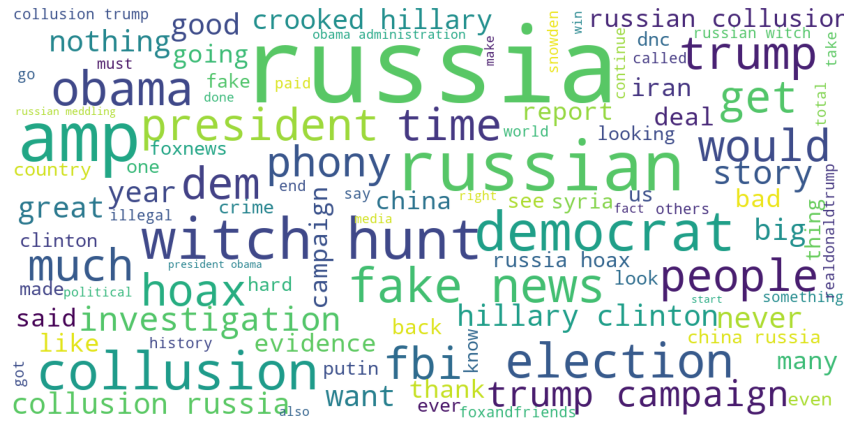

In [17]:
mueller_tweets = tweets[tweets['text_clean'].str.contains('russia')]
show_wordcloud(mueller_tweets, 'text_clean')

As expected, the phrases 'witch hunt' and 'collusion' are fairly large here since these were Trump's go-to attacks on Robert Mueller's investigation into the Trump-Russia involvement in the 2016 election.

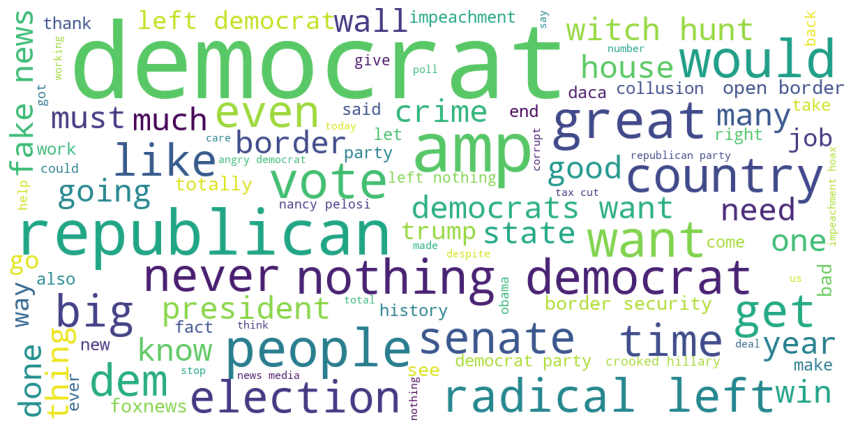

In [18]:
dem_tweets = tweets[tweets['text_clean'].str.contains('democrat')]
show_wordcloud(dem_tweets, 'text_clean')

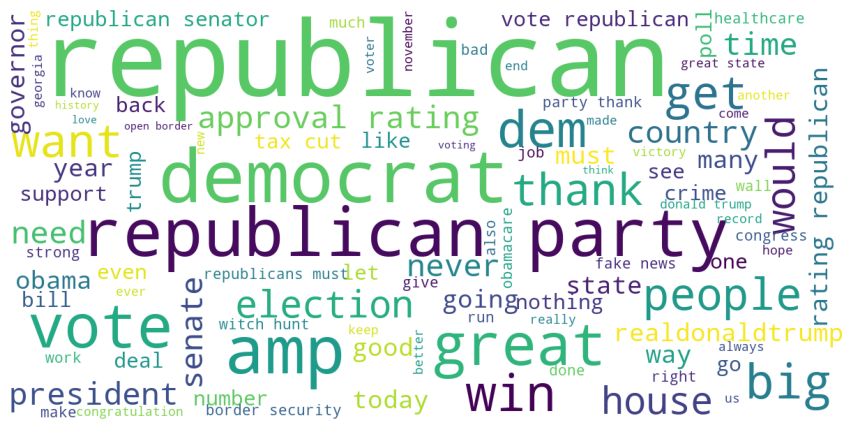

In [19]:
gop_tweets = tweets[tweets['text_clean'].str.contains('republican')]
show_wordcloud(gop_tweets, 'text_clean')

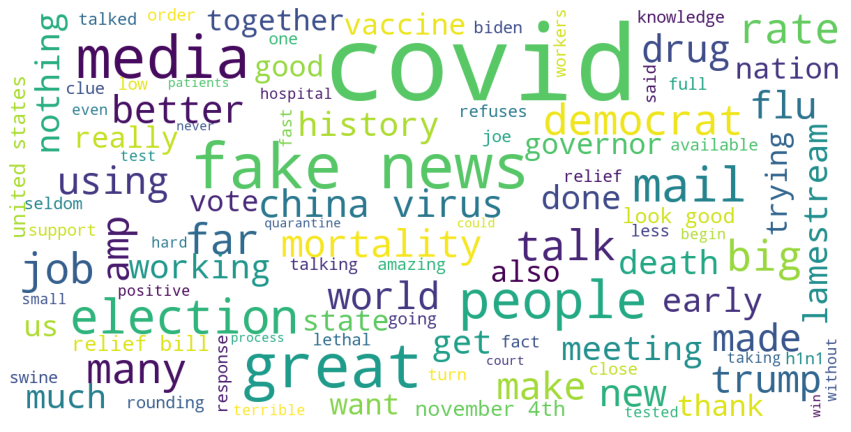

In [20]:
covid_tweets = tweets[tweets['text_clean'].str.contains('covid')]
show_wordcloud(covid_tweets, 'text_clean')

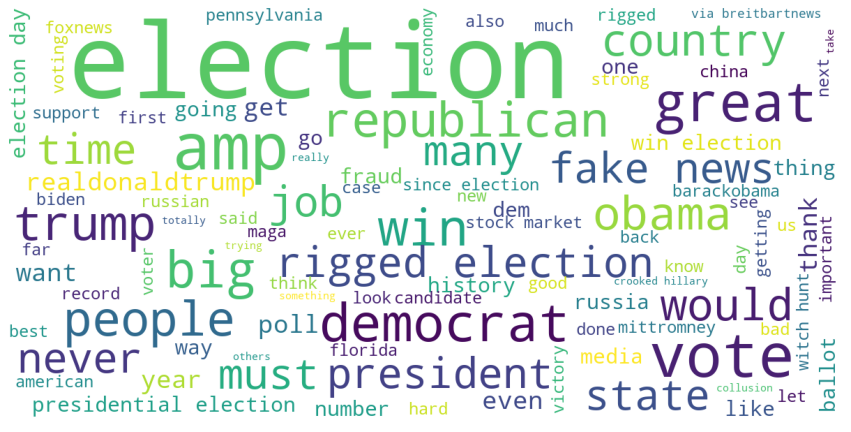

In [21]:
election_tweets = tweets[tweets['text_clean'].str.contains('election')]
show_wordcloud(election_tweets, 'text_clean')

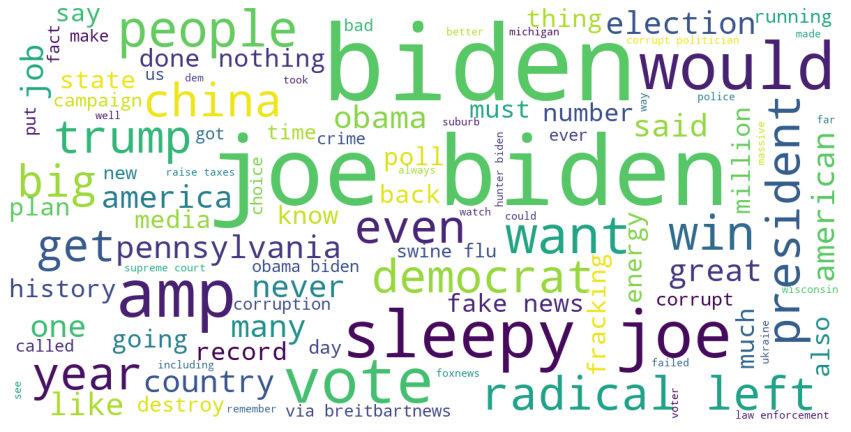

In [22]:
left_tweets = tweets[tweets['text_clean'].str.contains('biden')]
show_wordcloud(left_tweets, 'text_clean')

The wordclouds above show the concentration of words Trump used for various topics. Not surprisingly, he often referred to COVID-19 as the "china virus", associated all democrats with the "radical left", and held the opinion that the 2020 election was rigged.

## Just for Fun: Tweet Generator

### FastAI LSTM

In [23]:
from fastai import *
from fastai.text import *
from sklearn.model_selection import train_test_split

train_tweets, test_tweets = train_test_split(tweets, test_size=0.1, random_state=7)
colab_models_path = ''

lmdb = TextLMDataBunch.from_df(path=colab_models_path, train_df=train_tweets, valid_df=test_tweets, text_cols='text')
lml = language_model_learner(data=lmdb, arch=AWD_LSTM, pretrained=True, drop_mult=0.5)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [24]:
lml.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


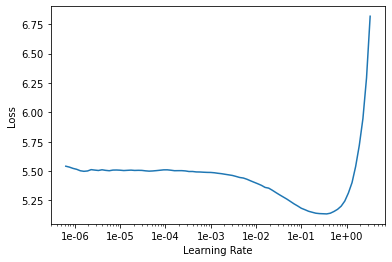

In [25]:
lml.recorder.plot()

In [26]:
lml.fit(epochs=10, lr=5e-2, wd=1e-8)

epoch,train_loss,valid_loss,accuracy,time
0,4.258624,3.862082,0.318359,00:51
1,4.027347,3.812692,0.321692,00:50
2,3.923792,3.793890,0.326531,00:51
3,3.884737,3.790300,0.329711,00:51
4,3.834646,3.797717,0.329624,00:51
5,3.802288,3.804597,0.330867,00:51
6,3.791142,3.812713,0.328109,00:51
7,3.768867,3.810297,0.329783,00:51
8,3.746727,3.825089,0.330716,00:51
9,3.738646,3.832983,0.332286,00:51


In [27]:
generated_tweets = []

for twt in range(30):
    sample = lml.predict(text='', n_words=30, temperature=0.7)
    sample_cleaned = [sentence for sentence in sample.split('xxbos') if sentence not in ['', ' ']]
    generated_tweets.append(sample_cleaned[0])
    
generated_tweets

[' Thank you ! ',
 ' The U.S. ',
 ' " " ',
 ' " " It was my great honor to sign the new US Poll Watcher . Sign up and sign up soon . The most',
 ' In Sen. Thomas Lauderdale Obama , i have made up China , on November 3rd . We have a massive deficit deficit',
 ' The Fake News Media is so dishonest about Obama ’s ineptitude and they are so dishonest . He is a joke ! ',
 ' " " @MARGIE352 : Keep up your open door open to doors and doors questions on Howard Stern . When we are going to attack',
 ' .@nbcnews is really bad and disgusting ! ',
 ' " " What the hell is much good for the White House News Organization The USA . They are not believable .',
 ' The United States - Mexico is doing a tremendous job at the United Nations CLAUSE . ',
 ' " " # Trump International Hotel & , Tower in Chicago . It \'s the best hotel stays Vancouver . ',
 ' " " @beaumontanthony : @realdonaldtrump Mr. Trump Country " " ',
 ' .@cher " " Many people have . The Party is so easy to beat . The Democrats are angry ! 

In [28]:
num_words = 0

for t in tweets['text_clean']:
    num_words += len(t.split(' '))
    
num_words / len(tweets)

18.96541669654167

In [31]:
lml.predict(text='Obama', n_words=30, temperature=0.5)

"Obama is a disaster to Iran and our Country . He 's incompetent , he 's a mess . xxbos The Democrats are doing a really"

### GPT-2 Medium (345M parameters)

In [32]:
!git clone https://github.com/openai/gpt-2.git

Cloning into 'gpt-2'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 4.38 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [33]:
%cd gpt-2/
!pip install tensorflow-gpu==1.15
!pip install -r requirements.txt
!python3 "/content/gpt-2/download_model.py" 345M

/content/gpt-2
     |████████████████████████████████| 411.5MB 41kB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 512kB 50.3MB/s 
     |████████████████████████████████| 3.8MB 39.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=075b4f16fd6fb6211b0b9ebf2b9a577ae825ef3145d3ea21e4e131c55a60f3b7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found 

Fetching checkpoint: 1.00kit [00:00, 925kit/s]                                                      
Fetching encoder.json: 1.04Mit [00:00, 4.54Mit/s]                                                   
Fetching hparams.json: 1.00kit [00:00, 931kit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 1.42Git [00:50, 28.0Mit/s]                                 
Fetching model.ckpt.index: 11.0kit [00:00, 9.17Mit/s]                                               
Fetching model.ckpt.meta: 927kit [00:00, 4.07Mit/s]                                                 
Fetching vocab.bpe: 457kit [00:00, 2.29Mit/s]                                                       


In [ ]:
# Code to generate corpus of Trump tweets if needed to a text file, filters out retweets.
# ---This step already completed in the tweets dataframe during cleanup step earlier in the notebook.
#
# djt_corpus = tweets[~tweets['text'].str.startswith('RT')]['text']
# pd.set_option('display.max_colwidth', -1)

# for t in (('Tweet: ' + djt_corpus[:10000])[::-1]): 
#     textfile = open('djtcorpus_06032020.txt', 'a')
#     textfile.write(t + '\n')
#     textfile.close()
#     print(t)

In [34]:
# Modify the interactive samples script in gpt-2/script by making a variable to store some of the text column from the tweets dataframe 
# and feed this to the tokenizer at the end. Also remove the for loops at the end and tune parameters to your liking. 
# Then run the script as below to generate some samples. 
!python3 "/content/gpt-2/src/gpt2_samples_script.py"


2021-03-06 19:34:53.086210: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-03-06 19:34:53.092013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-06 19:34:53.092571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2021-03-06 19:34:53.102992: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-03-06 19:34:53.311086: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-03-06 19:34:53.401735: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0


## Concluding Thoughts
From just the provided data, it was fairly easy to get a grasp of Trump's general tweeting behavior. As expected, President Trump feels negatively towards subjects that involve Democrats and positive towards subjects that involve the GOP/Republicans. Despite the language model only giving a baseline accuracy of just over 30%, the resulting generated tweets do in fact seem like something that Trump would put out, grammar and punctuation mistakes notwithstanding.

For further investigation, it would have been nice to have data regarding the number of replies/comments to his tweets. Even though he rarely goes back-and-forth directly with other users on the platform, this could give a better understanding of how many people interact with him. Additionally, a dataset of Trump's follower counts over time would've help get a better sense of his popularity and match growth spikes to various news-worthy events.

## References
*   Source of data & download page: https://www.thetrumparchive.com/faq
*   Twitter company statement on the permanent suspension of @realDonaldTrump: https://blog.twitter.com/en_us/topics/company/2020/suspension.html


